<a href="https://colab.research.google.com/github/jellyXuuuuu/CovidNetDeepLearning/blob/main/4_experiment_lung_rectangle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [ ]:
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2 as cv
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

import tensorflow.compat.v1 as tf
import os, argparse
import cv2
import pandas as pd
from tqdm import tqdm
import json

# Load files

In [ ]:
!cp -r 'drive/MyDrive/covid/models/' .

In [ ]:
!cp -r 'drive/MyDrive/covid/labels/' .

In [ ]:
!cp -r 'drive/MyDrive/covid/assets/' .

## Load other dataset

In [ ]:
# covid-chestxray-dataset
!wget https://github.com/ieee8023/covid-chestxray-dataset/archive/refs/heads/master.zip

--2023-03-12 23:50:02--  https://github.com/ieee8023/covid-chestxray-dataset/archive/refs/heads/master.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/ieee8023/covid-chestxray-dataset/zip/refs/heads/master [following]
--2023-03-12 23:50:02--  https://codeload.github.com/ieee8023/covid-chestxray-dataset/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 140.82.114.10
Connecting to codeload.github.com (codeload.github.com)|140.82.114.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip              [ <=>                ] 525.03M  20.8MB/s    in 25s     

2023-03-12 23:50:27 (20.8 MB/s) - ‘master.zip’ saved [550535079]



In [ ]:
!unzip master.zip

Archive:  master.zip
78543292f8b01d5e0ed1d0e15dce71949f0657bb
   creating: covid-chestxray-dataset-master/
   creating: covid-chestxray-dataset-master/.github/
 extracting: covid-chestxray-dataset-master/.github/FUNDING.yml  
   creating: covid-chestxray-dataset-master/.github/workflows/
  inflating: covid-chestxray-dataset-master/.github/workflows/tests.yml  
  inflating: covid-chestxray-dataset-master/.gitignore  
  inflating: covid-chestxray-dataset-master/README.md  
  inflating: covid-chestxray-dataset-master/SCHEMA.md  
   creating: covid-chestxray-dataset-master/annotations/
  inflating: covid-chestxray-dataset-master/annotations/covid-severity-scores.csv  
  inflating: covid-chestxray-dataset-master/annotations/imageannotation_ai_lung_bounding_boxes.json  
   creating: covid-chestxray-dataset-master/annotations/lungVAE-masks/
  inflating: covid-chestxray-dataset-master/annotations/lungVAE-masks/1-s2.0-S0140673620303706-fx1_lrg_mask.png  
  inflating: covid-chestxray-dataset-mas

# Show covid-model+gradcam plot graph
## for new final layer 
- update final layer name with 'conv5_block3_3_conv/BiasAdd:0'
- output tensor: dense_3/Softmax:0
- use code
[https://gist.github.com/nguyenhoa93/d49564875234f6722ff89e65db34a00b](https://https://gist.github.com/nguyenhoa93/d49564875234f6722ff89e65db34a00b)

In [ ]:
"""
Generate GradCAM for COVID-Net model: https://github.com/lindawangg/COVID-Net
By: Hoa Nguyen
Last updated: May 23, 2020
"""
# Dependencies
import numpy as np
# import tensorflow as tf
import tensorflow.compat.v1 as tf
import os, argparse
import cv2
import pandas as pd
from tqdm import tqdm
import json
tf.disable_v2_behavior()

# parser = argparse.ArgumentParser(description='COVID-Net Inference')
# parser.add_argument('-model', default="COVID-Net-Small.json", help="Path to model specification")
# parser.add_argument('-impath', default='./data/test', help='Path to image')
# parser.add_argument('-pred_class', help='Prediction result by COVID-Net. Should be: normal | pneumonia | COVID-19')
# parser.add_argument('-outdir', help="Output directory")

# args = parser.parse_args()
# model_info = json.load(open(args.model))

# weightspath = model_info["weightspath"]
# metaname = model_info["metaname"]
# ckptname = model_info["ckptname"]
weightspath = 'models/COVIDNet-CXR-Large/' 
  
# arguments:
IMAGE_PATH ="assets/ex-covid.jpeg"
output_node_names = "dense_3/Softmax:0" #norm_dense_2/Softmax
final_conv_name="conv5_block3_3_conv/BiasAdd:0"  
'''
#conv5_block3_1_conv/convolution, post_relu/Relu,post_bn/cond/FusedBatchNorm, 
#conv5_block3_out/add, conv5_block3_3_conv/convolution, conv5_block3_1_conv/convolution, 
#conv4_block3_1_bn/gamma/initial_value,conv4_block3_1_bn/gamma 
'''
model_path = 'models/COVIDNet-CXR-Large/model' #models/COVIDNet-CXR-2/model
model_path2 = 'models/COVIDNet-CXR-Large/model-8485'


metaname = 'model.meta'
ckptname = 'model'
args_n_classes = 2

args_testfolder = 'data/test'
args_trainfile = 'labels/train_COVIDx9B.txt'
args_testfile = 'labels/test_COVIDx9B.txt'

args_out_tensorname = 'dense_3/Softmax:0' #norm_dense_2/Softmax:0
args_logit_tensorname = 'norm_dense_2/MatMul:0'
args_is_severity_model = False
args_is_medusa_backbone = False

args_in_tensorname = 'input_1:0'
args_in_tensorname_medusa = 'input_1:0'
args_input_size = 224 # 480
args_input_size_medusa = 256
args_top_percent = 0.08

# save image
args_impath = "assets/ex-covid.jpeg"
args_pred_class = 'COVID-19'
args_outdir = './'

mapping = {'normal': 0, 'pneumonia': 1, 'COVID-19': 2}
inv_mapping = {0: 'normal', 1: 'pneumonia', 2: 'COVID-19'}

def crop_top(img, percent=0.15):
    offset = int(img.shape[0] * percent)
    return img[offset:]


def central_crop(img):
    size = min(img.shape[0], img.shape[1])
    offset_h = int((img.shape[0] - size) / 2)
    offset_w = int((img.shape[1] - size) / 2)
    return img[offset_h:offset_h + size, offset_w:offset_w + size]


def process_image_file(filepath, top_percent, size):
    if filepath.split(".")[-1] == "npy":
        x_arr = np.load(filepath)
        x_arr = x_arr * 255.0 / x_arr.max()
        img = np.stack((x_arr, x_arr, x_arr), axis=-1)
    else:
        img = cv2.imread(filepath)

    processed_img = crop_top(img, percent=top_percent)
    processed_img = central_crop(processed_img)
    processed_img = cv2.resize(processed_img, (size, size))
    return processed_img, img
  
class GradCAM:
    def __init__(self, graph, classes, outLayer, targetLayer=None):
        self.graph = graph
        self.classes = classes
        self.targetLayer = targetLayer
        self.outLayer = outLayer

        if self.targetLayer is None:
            self.target = self.find_target_tensor()
        else:
            self.target = self.graph.get_tensor_by_name(self.targetLayer)

    def find_target_tensor(self):
        """
        Find the last tensor that have 4D shape if targetLayer is not specified.
        :return:
        """
        tensor_names = [t.name for op in tf.get_default_graph().get_operations() for t in op.values() if
                   "save" not in str(t.name)]
        for tensor_name in reversed(tensor_names):
            tensor = self.graph.get_tensor_by_name(tensor_name)
            if len(tensor.shape) == 4:
                return tensor

        raise ValueError("Could not find 4D layer. Cannot apply GradCAM")

    def compute_grads(self):
        results = {} # grads of classes with keys being classes and values being normalized gradients
        for classIdx in self.classes:
            one_hot = tf.sparse_to_dense(classIdx, [len(self.classes)], 1.0)
            signal = tf.multiply(self.graph.get_tensor_by_name(self.outLayer),one_hot)
            loss = tf.reduce_mean(signal)

            grads = tf.gradients(loss, self.target)[0]

            norm_grads = tf.div(grads, tf.sqrt(tf.reduce_mean(tf.square(grads)))+tf.constant(1e-5))

            results[classIdx] = norm_grads

        return results


def generate_cam(conv_layer_out, grads_val, upsample_size):
    weights = np.mean(grads_val, axis=(0,1))
    cam = np.zeros(conv_layer_out.shape[0:2], dtype=np.float32)

    # Weight averaginng
    for i, w in enumerate(weights):
        cam += w*conv_layer_out[:,:,i]

    # Apply reLU
    cam = np.maximum(cam, 0)
    cam = cam/np.max(cam)
    cam = cv2.resize(cam, upsample_size)

    # Convert to 3D
    cam3 = np.expand_dims(cam, axis=2)
    cam3 = np.tile(cam3,[1,1,3])

    return cam3



# if __name__ == '__main__':
sess = tf.Session()
# tf.get_default_graph()
# saver = tf.train.import_meta_graph(os.path.join(weightspath, metaname))
saver = tf.train.import_meta_graph(model_path + '.meta')
# saver.restore(sess, os.path.join(weightspath, ckptname))
# saver.restore(sess, weightspath)
saver.restore(sess, model_path2)

graph = tf.get_default_graph()

image_tensor = graph.get_tensor_by_name(args_in_tensorname)
gradCam = GradCAM(graph=graph, classes = [0,1,2], outLayer=args_out_tensorname, targetLayer=final_conv_name)

grads = gradCam.compute_grads()

x, origin_im = process_image_file(args_impath, args_top_percent, args_input_size)
img_arr = np.asanyarray(x)
size_upsample = (origin_im.shape[1],origin_im.shape[0]) # (w, h)

x = x.astype('float32') / 255.0
output, grads_val = sess.run([gradCam.target, grads[mapping[args_pred_class]]], feed_dict={image_tensor: np.expand_dims(x, axis=0)})

cam3 = generate_cam(output[0],grads_val[0],size_upsample)


# Overlay cam on image
cam3 = np.uint8(255*cam3)
cam3 = cv2.applyColorMap(cam3, cv2.COLORMAP_JET)

new_im = cam3*0.3 + origin_im*0.5

im_name = args_impath.split("/")[-1]
ext = im_name.split(".")[-1]

# Save the GradCAM
cv2.imwrite(os.path.join(args_outdir, "{}_{}png".format(args_pred_class, im_name.rstrip(ext))), new_im)

print("GradCAM image is save in ", args_outdir)

Instructions for updating:
non-resource variables are not supported in the long term
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


GradCAM image is save in  ./


## make it as a method

In [ ]:
def main_grad(args_impath):
  # # add more photo
  # args_impath = "./covid-chestxray-dataset-master/images/000001-1.jpg"
  image_tensor = graph.get_tensor_by_name(args_in_tensorname)
  gradCam = GradCAM(graph=graph, classes = [0,1,2], outLayer=args_out_tensorname, targetLayer=final_conv_name)

  grads = gradCam.compute_grads()

  x, origin_im = process_image_file(args_impath, args_top_percent, args_input_size)
  img_arr = np.asanyarray(x)
  size_upsample = (origin_im.shape[1],origin_im.shape[0]) # (w, h)

  x = x.astype('float32') / 255.0
  output, grads_val = sess.run([gradCam.target, grads[mapping[args_pred_class]]], feed_dict={image_tensor: np.expand_dims(x, axis=0)})

  cam3 = generate_cam(output[0],grads_val[0],size_upsample)

  # Overlay cam on image
  cam3 = np.uint8(255*cam3)
  cam3 = cv2.applyColorMap(cam3, cv2.COLORMAP_JET)
  
  im_name = args_impath.split("/")[-1]
  ext = im_name.split(".")[-1]


  # show!!!!
  cam3_resize = cv.resize(cam3, (224, 224))
  
  # cv2.imwrite("cam-1.png", cam3_resize)
  

  new_im = cam3*0.3 + origin_im*0.5


  # Save the GradCAM
  cv2.imwrite(os.path.join(args_outdir, "{}_{}png".format(args_pred_class, im_name.rstrip(ext))), new_im)

  # print("GradCAM image is save in ", args_outdir)

  # show images:
  # imagepath = "assets/ex-covid.jpeg"
  img_m = cv.imread(args_impath)
  img_m = cv.resize(img_m, (224, 224))

  # display(Image(imagepath))
  cv2_imshow(img_m)  # oringinal
  new_im_2 = cv.resize(new_im, (224, 224))
  cv2_imshow(new_im_2)  # grad-cam

  cv2_imshow(cam3_resize) # grad-cam-explain

  return img_m, new_im_2, cam3_resize

# Test for ex-covid.jpeg

Current img: ./assets/ex-covid.jpeg


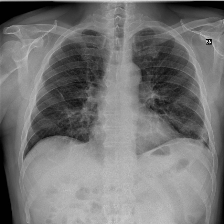

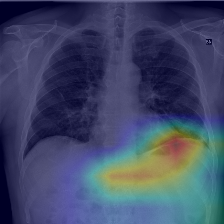

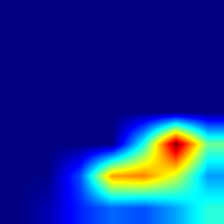

In [ ]:
temp_name = './assets/ex-covid.jpeg'
print("Current img:", temp_name)
# img_m = cv.imread(temp_name)
# img_m = cv.resize(img_m, (224, 224))
# cv2_imshow(img_m)
img_m, new_im_2, cam3_resize = main_grad(temp_name)
# print(i, PCR_result_all[num])

In [ ]:
img_m, new_im_2, cam3_resize

(array([[[184, 184, 184],
         [179, 179, 179],
         [178, 178, 178],
         ...,
         [167, 167, 167],
         [167, 167, 167],
         [169, 169, 169]],
 
        [[ 92,  92,  92],
         [ 79,  79,  79],
         [ 72,  72,  72],
         ...,
         [  9,   9,   9],
         [ 10,  10,  10],
         [  9,   9,   9]],
 
        [[  5,   5,   5],
         [  1,   1,   1],
         [  1,   1,   1],
         ...,
         [  1,   1,   1],
         [  1,   1,   1],
         [  1,   1,   1]],
 
        ...,
 
        [[  1,   1,   1],
         [  1,   1,   1],
         [  1,   1,   1],
         ...,
         [ 15,  15,  15],
         [ 12,  12,  12],
         [  1,   1,   1]],
 
        [[  1,   1,   1],
         [  1,   1,   1],
         [  1,   1,   1],
         ...,
         [ 14,  14,  14],
         [ 12,  12,  12],
         [  1,   1,   1]],
 
        [[  1,   1,   1],
         [  1,   1,   1],
         [  1,   1,   1],
         ...,
         [ 13,  13,  13],
  

## show lung rectangle

<Figure size 432x288 with 0 Axes>

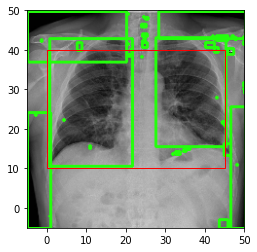

In [ ]:
# show lung using rectangle

import matplotlib.pyplot as plt
fig = plt.figure()
# ax = fig.add_subplot(1,1,1)


img = img_m
h,w,c = img.shape

fig, ax = plt.subplots(1, 1)



# # left lung
# rect1 = plt.Rectangle((0.1,10), 20, 30, fill=False, edgecolor = 'red',linewidth=1)  
# # right lung
# rect2 = plt.Rectangle((25,10), 20, 30, fill=False, edgecolor = 'red',linewidth=1)
# together
rect = plt.Rectangle((0.1,10), 45, 30, fill=False, edgecolor = 'red',linewidth=1) 
ax.add_patch(rect)
# ax.add_patch(rect2)
ax.imshow(img, extent=[-5, 50, -5, 50])

plt.show()
# rect = patches.Rectangle((coord[0], coord[1]), coord[2], coord[3], 
#         						linewidth=1, edgecolor='r',facecolor='none')

## show bounding box

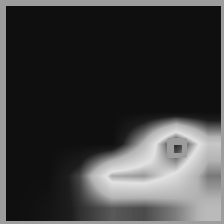

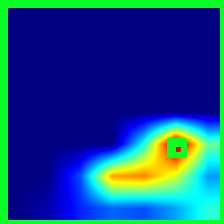

In [ ]:
# bounding box
# Load image, grayscale, Otsu's threshold 
image = cam3_resize
original = image.copy()
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
cv2_imshow(gray)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

# Find contours, obtain bounding box, extract and save ROI
ROI_number = 0
cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    x,y,w,h = cv2.boundingRect(c)
    cv2.rectangle(image, (x, y), (x + w, y + h), (36,255,12), 2)
    ROI = original[y:y+h, x:x+w]
    cv2.imwrite('ROI_{}.png'.format(ROI_number), ROI)
    ROI_number += 1

cv2_imshow(image)
# cv2.waitKey()

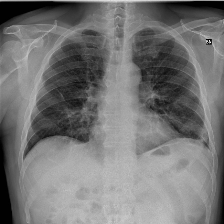

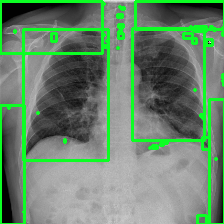

In [ ]:
# bounding box
# Load image, grayscale, Otsu's threshold 
image = img_m
original = image.copy()
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
cv2_imshow(gray)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

# Find contours, obtain bounding box, extract and save ROI
ROI_number = 0
cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    x,y,w,h = cv2.boundingRect(c)
    cv2.rectangle(image, (x, y), (x + w, y + h), (36,255,12), 2)
    ROI = original[y:y+h, x:x+w]
    cv2.imwrite('ROI_{}.png'.format(ROI_number), ROI)
    ROI_number += 1

cv2_imshow(image)
# cv2.waitKey()

## show IOU

In [ ]:
import numpy as np

def IoU(box1: np.ndarray, box2: np.ndarray):
    """
    calculate intersection over union cover percent
    :param box1: box1 with shape (N,4) or (N,2,2) or (2,2) or (4,). first shape is preferred
    :param box2: box2 with shape (N,4) or (N,2,2) or (2,2) or (4,). first shape is preferred
    :return: IoU ratio if intersect, else 0
    """
    # first unify all boxes to shape (N,4)
    if box1.shape[-1] == 2 or len(box1.shape) == 1:
        box1 = box1.reshape(1, 4) if len(box1.shape) <= 2 else box1.reshape(box1.shape[0], 4)
    if box2.shape[-1] == 2 or len(box2.shape) == 1:
        box2 = box2.reshape(1, 4) if len(box2.shape) <= 2 else box2.reshape(box2.shape[0], 4)
    point_num = max(box1.shape[0], box2.shape[0])
    b1p1, b1p2, b2p1, b2p2 = box1[:, :2], box1[:, 2:], box2[:, :2], box2[:, 2:]

    # mask that eliminates non-intersecting matrices
    base_mat = np.ones(shape=(point_num,))
    base_mat *= np.all(np.greater(b1p2 - b2p1, 0), axis=1)
    base_mat *= np.all(np.greater(b2p2 - b1p1, 0), axis=1)

    # I area
    intersect_area = np.prod(np.minimum(b2p2, b1p2) - np.maximum(b1p1, b2p1), axis=1)
    # U area
    union_area = np.prod(b1p2 - b1p1, axis=1) + np.prod(b2p2 - b2p1, axis=1) - intersect_area
    # IoU
    intersect_ratio = intersect_area / union_area
    print("base_mat: ", base_mat)
    print("intersect_ratio: ", intersect_ratio)
    return base_mat * intersect_ratio

### detection

In [ ]:
# import the necessary packages
from collections import namedtuple
import numpy as np
import cv2
# define the `Detection` object
Detection = namedtuple("Detection", ["image_path", "gt", "pred"])

In [ ]:
def bb_intersection_over_union(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
	# compute the area of intersection rectangle
	interArea = max(0, abs(xB - xA + 1)) * max(0, abs(yB - yA + 1))
	print("test for interarea:", interArea)
	print("xA, yA, xB, yB:", xA, yA, xB, yB)
  
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = abs((boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1))
	boxBArea = abs((boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1))
	print("boxAArea:", boxAArea)
	print("boxBArea", boxBArea)
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
	print("iou: ", iou)
	# return the intersection over union value
	return iou

test for interarea: 120900
xA, yA, xB, yB: 301 504 600 100
boxAArea: 199899
boxBArea 30906
iou:  1.1000409444520267
COVID-19_ex-covid.png: 1.10004094
base_mat:  [0.]
intersect_ratio:  [1.09505938]
iou2 [0.]


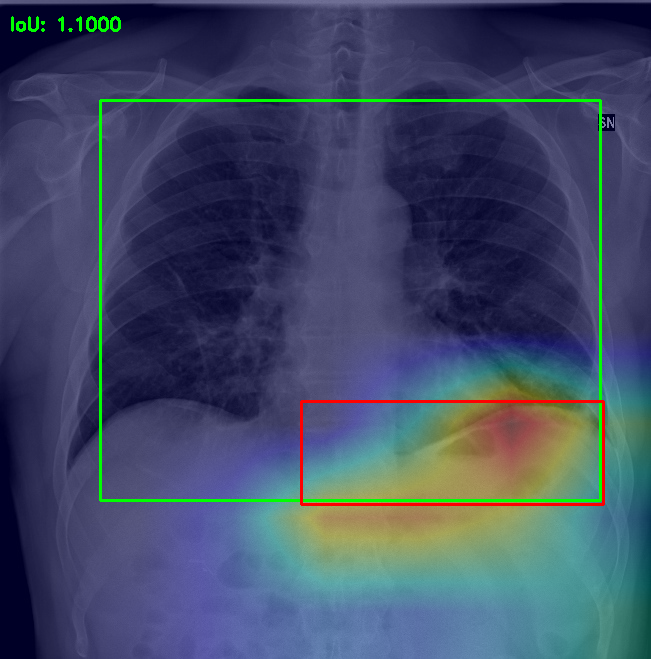

In [ ]:
# define the list of example detections
examples = [
	Detection("ex-covid.jpg", [39, 63, 203, 112], [54, 66, 198, 114]),
	Detection("image_0016.jpg", [49, 75, 203, 125], [42, 78, 186, 126]),
	Detection("image_0075.jpg", [31, 69, 201, 125], [18, 63, 235, 135]),
	Detection("image_0090.jpg", [50, 72, 197, 121], [54, 72, 198, 120]),
	Detection("image_0120.jpg", [35, 51, 196, 110], [36, 60, 180, 108])]

# loop over the example detections
# for detection in examples:
	# load the image
detection = Detection('COVID-19_ex-covid.png', [100, 500, 600, 100], [301, 504, 603, 401]) # ./assets/ex-covid.jpeg

image = cv2.imread(detection.image_path)
# draw the ground-truth bounding box along with the predicted

# bounding box

# # left lung
# rect = plt.Rectangle((0.1,10), 20, 30, fill=False, edgecolor = 'red',linewidth=1)  
# # right lung
# rect2 = plt.Rectangle((25,10), 20, 30, fill=False, edgecolor = 'red',linewidth=1)  
# rect = plt.Rectangle((0.1,10), 45, 30, fill=False, edgecolor = 'red',linewidth=1)

cv2.rectangle(image, tuple(detection.gt[:2]), 
  tuple(detection.gt[2:]), (0, 255, 0), 2)
cv2.rectangle(image, tuple(detection.pred[:2]), 
  tuple(detection.pred[2:]), (0, 0, 255), 2)
# compute the intersection over union and display it
iou = bb_intersection_over_union(detection.gt, detection.pred)
cv2.putText(image, "IoU: {:.4f}".format(iou), (10, 30),
  cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
print("{}: {:.8f}".format(detection.image_path, iou))
array1 = np.array(detection.gt)
array2 = np.array(detection.pred)
iou2 = IoU(array1, array2)
print("iou2", iou2)

# show the output image
cv2_imshow(image)
	# cv2.waitKey(0)